In [1]:
import os
from glob import glob
import hashlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import deepcopy
import ipynbname
import matplotlib.pyplot as plt
import shap
from datetime import datetime
import re

# Constants
EXPERIMENT_NAME = "nursing_home"
DATA_PATH = f"..{os.sep}data{os.sep}"

In [2]:
current_time = datetime.now()
print("Current time is:",current_time)

nb_fname = ipynbname.name()
print("File:",nb_fname)

experiment_number = int(re.findall(r'\d+', nb_fname)[0])
print(f"Experiment Number: {experiment_number}")  # Output: 01

Current time is: 2024-12-05 21:52:04.768119
File: machine_learning_experiment08
Experiment Number: 8


In [3]:
# Function to generate a consistent hash number for a given file name
def generate_hash_number(file_name):
    """
    Generates a consistent hash number based on the file name.
    
    Args:
        file_name (str): The file name to hash.
    
    Returns:
        int: A 32-bit hash number.
    """
    # Create an MD5 hash object
    hash_obj = hashlib.md5()
    
    # Update the hash object with the file name, encoded to bytes
    hash_obj.update(file_name.encode())

    # Convert the hash to an integer and ensure the range fits 32-bit
    return int(hash_obj.hexdigest(), 16) % (2**32)

# Generate experiment seed from experiment name
initial_seed = generate_hash_number(EXPERIMENT_NAME)
print(f"Experiment Name: {EXPERIMENT_NAME}, Initial Seed: {initial_seed}")

Experiment Name: nursing_home, Initial Seed: 127573839


In [4]:
# Set the seed for reproducibility
np.random.seed(initial_seed)

# Generate a list of 5 random integers in the range of 32-bit integers
random_integers_list = np.random.randint(low=0, high=2**31 - 1, size=10).tolist()
print("Random Integers List:", random_integers_list)
seed = random_integers_list[experiment_number-1]
# Load clinical microbiome data
df_path = glob(f'{DATA_PATH}*clinical_microbiome_df*')[0]
print(f"Data File Path: {df_path}")

clinical_microbiome_df = pd.read_csv(df_path)
print("Clinical Microbiome Data Loaded.")

# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)

print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)
print(f"Seed in this experiment: {seed}")

Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Data File Path: ../data/clinical_microbiome_df.csv
Clinical Microbiome Data Loaded.
Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64
Seed in this experiment: 513873336


In [5]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [6]:
clinical_microbiome_df = clinical_microbiome_df[clinical_microbiome_df["Dementia Other"] != 1]
# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)
print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)

Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64


In [7]:
clinical_summaries_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}clinical_summaries_df*")[0])
clinical_summaries_df

,Feature,Description,Group Characteristics,Summary
0,Sample ID,Unique identifier for biological or clinical s...,Study Identification,### Clinical Feature Summary\n\n#### Feature: ...
1,study_id,Identifier for the specific study or research ...,Study Identification,"### Clinical Feature Definitions, Scope, and R..."
2,day,Day of data collection or relevant event.,Temporal Information,### Clinical Feature Summary for Alzheimer's D...
3,Date Sample,Date when the sample was collected.,Temporal Information,### Clinical Feature Summary\n\n#### Feature: ...
4,age,Age of the participant.,Demographic Information,### Clinical Feature Summary: Age\n\n**Definit...
...,...,...,...,...
98,Severe Liver disease,Advanced liver disease diagnosis.,Hepatic Condition,### Clinical Feature: Severe Liver Disease\n\n...
99,ostomy,Presence of an ostomy.,Surgical History,### Clinical Feature: Ostomy\n\n**Definition:*...
100,Alzheimers,Diagnosis of Alzheimer’s disease.,Neurological Condition,### Clinical Feature Summary: Alzheimer's Dise...
101,Dementia Other,Other forms of dementia.,Neurological Condition,### Clinical Feature: Dementia Other\n\n**Defi...


In [8]:
clinical_summaries_df['Feature'].tolist()[:5]

['Sample ID', 'study_id', 'day', 'Date Sample', 'age']

In [9]:
clinical_summaries_df[['Feature']][clinical_summaries_df['Feature'].str.startswith(('c', 'C'))]

,Feature
10,clinical_frailty_scale
16,cholinesterase inhibitors
17,Calcium-channel blockers
58,Calcium Channel Modulators
59,Carbonic Anhydrase Inhibitor
60,Carboxamides
71,Chemotherapy Medication
81,COPD
86,Congestive heart failure
88,Cerebrovascular disease: CVA with mild or no r...


In [10]:
bacteria_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}bacteria_df*")[0])
bacteria_df.species_name.tolist()[:5]

['Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Eubacterium_siraeum',
 'Gemmiger_formicilis',
 'Eubacterium_rectale']

In [11]:
set(bacteria_df.species_name.tolist()[:5])

{'Eubacterium_rectale',
 'Eubacterium_siraeum',
 'Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Gemmiger_formicilis'}

In [12]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [13]:
import os
from math import ceil
from pynvml import nvmlInit, nvmlDeviceGetCount

# Function to get the number of GPUs available
def get_num_gpus():
    try:
        nvmlInit()
        return nvmlDeviceGetCount()
    except Exception as e:
        print(f"Error accessing NVML: {e}")
        return 0

# Function to list all .ipynb files in the current directory
def get_notebook_files():
    return [f for f in os.listdir('.') if f.endswith('.ipynb')]

# Function to evenly distribute files across GPUs
def distribute_files_evenly(files, num_gpus):
    """
    Distributes files evenly across all available GPUs.
    
    Args:
        files (list): List of file names to distribute.
        num_gpus (int): Number of GPUs available.
        
    Returns:
        dict: Distribution of files per GPU.
    """
    distribution = {f"cuda:{i}": [] for i in range(num_gpus)}
    for idx, file in enumerate(files):
        # Assign each file to a GPU in round-robin fashion
        gpu_id = idx % num_gpus
        distribution[f"cuda:{gpu_id}"].append(file)
    return distribution

# Function to get GPU ID for a specific notebook file
def get_gpu_for_file(nb_fname, file_distribution):
    """
    Finds the GPU ID for a given notebook file based on the distribution.
    
    Args:
        nb_fname (str): Notebook file name to find the GPU for.
        file_distribution (dict): Distribution of files per GPU.
    
    Returns:
        str: GPU ID (e.g., "cuda:0") or "Unassigned" if the file is not found.
    """
    for gpu, files in file_distribution.items():
        if nb_fname in files:
            return gpu
    return "cpu"

# Main logic for the notebook
def assign_notebooks_to_gpus():
    # Get the number of GPUs
    num_gpus = get_num_gpus()
    if num_gpus == 0:
        print("No GPUs available. Using CPU for all tasks.")
        return {"cpu": get_notebook_files()}
    
    # Get the list of .ipynb files
    notebook_files = get_notebook_files()
    if not notebook_files:
        print("No .ipynb files found in the current directory.")
        return {}
    
    # Evenly distribute files across GPUs
    file_distribution = distribute_files_evenly(notebook_files, num_gpus)
    
    # Display the distribution in the notebook
    for gpu, files in file_distribution.items():
        print(f"{gpu}: {files}")
    
    return file_distribution

# Run the assignment logic
file_distribution = assign_notebooks_to_gpus()

# Get the GPU ID for the specific notebook file
device = get_gpu_for_file(f"{nb_fname}.ipynb", file_distribution)

print(f"Initial seed: {initial_seed}")
print(f"Random Integers List: {random_integers_list}")
# Print the result
print(f"Notebook '{nb_fname}.ipynb' is assigned to device: {device} with seed {seed}.")

cuda:0: ['machine_learning_experiment03.ipynb', 'machine_learning_experiment06.ipynb', 'machine_learning_experiment08.ipynb']
cuda:1: ['machine_learning_experiment09.ipynb', 'machine_learning_experiment07.ipynb', 'machine_learning_experiment10.ipynb']
cuda:2: ['machine_learning_experiment02.ipynb', 'machine_learning_experiment04.ipynb']
cuda:3: ['machine_learning_experiment05.ipynb', 'machine_learning_experiment01.ipynb']
Initial seed: 127573839
Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Notebook 'machine_learning_experiment08.ipynb' is assigned to device: cuda:0 with seed 513873336.


Experiment number: 8 | Seed number: 513873336
No overlap Study ID found.
No overlap Sample ID found.


[I 2024-12-05 21:52:05,819] A new study created in memory with name: no-name-aef0efcc-6351-4caf-9f80-74c2ee5b2e91


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:52:09,282] Trial 0 finished with value: 0.6447128750838845 and parameters: {'threshold': '0.5*mean', 'max_features': 651, 'norm_order': 2, 'learning_rate': 0.1284047636763718, 'max_depth': 26, 'min_child_weight': 4, 'subsample': 0.5392653846767926, 'colsample_bytree': 0.5826091998727425, 'gamma': 7.499629186929128, 'reg_alpha': 8.070989845131356, 'reg_lambda': 6.361738342884414, 'n_estimators': 173}. Best is trial 0 with value: 0.6447128750838845.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:52:11,697] Trial 1 finished with value: 0.7567802805035186 and parameters: {'threshold': 'median', 'max_features': 727, 'norm_order': 1, 'learning_rate': 0.3544837564812231, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.7578602667045904, 'colsample_bytree': 0.6648658455755063, 'gamma': 5.7308761500271554, 'reg_alpha': 4.422798047915457, 'reg_lambda': 4.699944351224341, 'n_estimators': 193}. Best is trial 1 with value: 0.7567802805035186.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:52:15,050] Trial 2 finished with value: 0.7477471904320033 and parameters: {'threshold': 'median', 'max_features': 161, 'norm_order': 2, 'learning_rate': 0.26941824238298495, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.9555770227510776, 'colsample_bytree': 0.6724936388478548, 'gamma': 1.3928963635941616, 'reg_alpha': 1.342050849807852, 'reg_lambda': 9.188079086417186, 'n_estimators': 184}. Best is trial 1 with value: 0.7567802805035186.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:52:17,970] Trial 3 finished with value: 0.7335257335257334 and parameters: {'threshold': '0.5*mean', 'max_features': 165, 'norm_order': 2, 'learning_rate': 0.11024983215470781, 'max_depth': 29, 'min_child_weight': 5, 'subsample': 0.8183385055197495, 'colsample_bytree': 0.515306884974108, 'gamma': 7.089239989987614, 'reg_alpha': 3.0505297323622003, 'reg_lambda': 1.2919445934485352, 'n_estimators': 77}. Best is trial 1 with value: 0.7567802805035186.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:52:20,809] Trial 4 finished with value: 0.6884824248280058 and parameters: {'threshold': 'mean', 'max_features': 21, 'norm_order': 1, 'learning_rate': 0.35228094424534995, 'max_depth': 21, 'min_child_weight': 5, 'subsample': 0.7753820209922886, 'colsample_bytree': 0.7682464661336805, 'gamma': 7.554056658862205, 'reg_alpha': 6.363933957105013, 'reg_lambda': 9.986803475595872, 'n_estimators': 112}. Best is trial 1 with value: 0.7567802805035186.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:52:25,466] Trial 5 finished with value: 0.6991822991822992 and parameters: {'threshold': '1.5*mean', 'max_features': 372, 'norm_order': 1, 'learning_rate': 0.26049192406069627, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.6026868333117377, 'colsample_bytree': 0.96999267809958, 'gamma': 8.814229768150238, 'reg_alpha': 5.322658652879296, 'reg_lambda': 4.656946357516105, 'n_estimators': 252}. Best is trial 1 with value: 0.7567802805035186.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:52:28,804] Trial 6 finished with value: 0.6744676365169724 and parameters: {'threshold': 'mean', 'max_features': 933, 'norm_order': 1, 'learning_rate': 0.047842728745433445, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7090252102277441, 'colsample_bytree': 0.6850578806554768, 'gamma': 8.095349970634192, 'reg_alpha': 9.37555887090092, 'reg_lambda': 4.456812629403735, 'n_estimators': 153}. Best is trial 1 with value: 0.7567802805035186.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:52:32,029] Trial 7 finished with value: 0.6883040935672514 and parameters: {'threshold': '1.5*mean', 'max_features': 713, 'norm_order': 1, 'learning_rate': 0.3351592372174891, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.7640550271854143, 'colsample_bytree': 0.6262943348471169, 'gamma': 7.392428331301266, 'reg_alpha': 5.085241735225376, 'reg_lambda': 4.578304739528224, 'n_estimators': 99}. Best is trial 1 with value: 0.7567802805035186.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:52:36,791] Trial 8 finished with value: 0.7174196174196176 and parameters: {'threshold': '1.5*mean', 'max_features': 68, 'norm_order': 1, 'learning_rate': 0.047743359579434326, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.5654351830486434, 'colsample_bytree': 0.5619036486147243, 'gamma': 0.9599881467297944, 'reg_alpha': 3.6375993641265545, 'reg_lambda': 0.9065665882754315, 'n_estimators': 136}. Best is trial 1 with value: 0.7567802805035186.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:52:40,700] Trial 9 finished with value: 0.7229583975346688 and parameters: {'threshold': 'very_low', 'max_features': 834, 'norm_order': 1, 'learning_rate': 0.17565786883815163, 'max_depth': 27, 'min_child_weight': 8, 'subsample': 0.8205108317021743, 'colsample_bytree': 0.7050269644953532, 'gamma': 7.458124440308525, 'reg_alpha': 3.596840036206345, 'reg_lambda': 6.099128471683622, 'n_estimators': 177}. Best is trial 1 with value: 0.7567802805035186.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:52:44,323] Trial 10 finished with value: 0.8002662182990052 and parameters: {'threshold': 'median', 'max_features': 1043, 'norm_order': 2, 'learning_rate': 0.4928687709592974, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.9516399397042397, 'colsample_bytree': 0.8092545574636241, 'gamma': 3.85278713492786, 'reg_alpha': 0.5708674282797395, 'reg_lambda': 2.7816702166154794, 'n_estimators': 299}. Best is trial 10 with value: 0.8002662182990052.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:52:47,794] Trial 11 finished with value: 0.7995000240373059 and parameters: {'threshold': 'median', 'max_features': 1026, 'norm_order': 2, 'learning_rate': 0.4759284825874146, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.9588191125762644, 'colsample_bytree': 0.8336257501320667, 'gamma': 3.9921934915854136, 'reg_alpha': 0.6906631057416952, 'reg_lambda': 2.7315644686762854, 'n_estimators': 296}. Best is trial 10 with value: 0.8002662182990052.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:52:51,568] Trial 12 finished with value: 0.8303602058319038 and parameters: {'threshold': 'median', 'max_features': 1039, 'norm_order': 2, 'learning_rate': 0.4979779690590987, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.9935303994009679, 'colsample_bytree': 0.8362029937337716, 'gamma': 3.3360994247112, 'reg_alpha': 0.06839128891767943, 'reg_lambda': 2.4780732997502426, 'n_estimators': 297}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:52:55,063] Trial 13 finished with value: 0.7796722378379591 and parameters: {'threshold': 'median', 'max_features': 1036, 'norm_order': 2, 'learning_rate': 0.49895156534344315, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.9805413542354188, 'colsample_bytree': 0.8749117469464303, 'gamma': 3.0200026666325472, 'reg_alpha': 1.8433638510158044, 'reg_lambda': 2.6044374210901378, 'n_estimators': 295}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:52:59,175] Trial 14 finished with value: 0.7527562749237626 and parameters: {'threshold': 'median', 'max_features': 417, 'norm_order': 2, 'learning_rate': 0.43300854630219054, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.8914712109426047, 'colsample_bytree': 0.8882094616512313, 'gamma': 2.319898235196325, 'reg_alpha': 0.2418640858195676, 'reg_lambda': 2.7439644914311234, 'n_estimators': 243}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:53:02,638] Trial 15 finished with value: 0.7382902658145781 and parameters: {'threshold': 'very_low', 'max_features': 894, 'norm_order': 2, 'learning_rate': 0.40337992425631297, 'max_depth': 11, 'min_child_weight': 7, 'subsample': 0.9007191120887732, 'colsample_bytree': 0.7882204173918028, 'gamma': 5.073252112392618, 'reg_alpha': 1.9674600804712277, 'reg_lambda': 0.44577656275273814, 'n_estimators': 248}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:53:06,231] Trial 16 finished with value: 0.7638655462184873 and parameters: {'threshold': 'median', 'max_features': 800, 'norm_order': 2, 'learning_rate': 0.41616277238481586, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.899829856061691, 'colsample_bytree': 0.9743956468143513, 'gamma': 3.377287321731849, 'reg_alpha': 0.00806719507643805, 'reg_lambda': 2.0592985626636544, 'n_estimators': 219}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:53:10,719] Trial 17 finished with value: 0.8205131131885232 and parameters: {'threshold': 'median', 'max_features': 561, 'norm_order': 2, 'learning_rate': 0.4634180234822175, 'max_depth': 23, 'min_child_weight': 2, 'subsample': 0.6719703033018473, 'colsample_bytree': 0.9076544946921576, 'gamma': 0.012484727234804538, 'reg_alpha': 2.3204428114476165, 'reg_lambda': 3.4832145174586615, 'n_estimators': 284}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:53:14,523] Trial 18 finished with value: 0.8044320758606474 and parameters: {'threshold': 'median', 'max_features': 502, 'norm_order': 2, 'learning_rate': 0.43168781294009323, 'max_depth': 23, 'min_child_weight': 2, 'subsample': 0.6102366562085535, 'colsample_bytree': 0.9020227160109796, 'gamma': 0.15283308692455444, 'reg_alpha': 2.580270603047044, 'reg_lambda': 6.159849126155122, 'n_estimators': 268}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:53:18,105] Trial 19 finished with value: 0.7083492698350252 and parameters: {'threshold': 'mean', 'max_features': 310, 'norm_order': 2, 'learning_rate': 0.2999571328760251, 'max_depth': 24, 'min_child_weight': 10, 'subsample': 0.676303625345143, 'colsample_bytree': 0.9294768437888627, 'gamma': 9.969404505897213, 'reg_alpha': 1.6101882287800986, 'reg_lambda': 3.7419663594944574, 'n_estimators': 211}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:53:21,447] Trial 20 finished with value: 0.771088499466114 and parameters: {'threshold': 'very_low', 'max_features': 529, 'norm_order': 2, 'learning_rate': 0.19324719604696214, 'max_depth': 20, 'min_child_weight': 4, 'subsample': 0.6778751610504025, 'colsample_bytree': 0.8486998448772346, 'gamma': 1.8900571844945377, 'reg_alpha': 6.787119149732559, 'reg_lambda': 7.574805560564127, 'n_estimators': 270}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:53:25,537] Trial 21 finished with value: 0.7962962962962963 and parameters: {'threshold': 'median', 'max_features': 591, 'norm_order': 2, 'learning_rate': 0.44956292327517156, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.6170087709117246, 'colsample_bytree': 0.9307609494739112, 'gamma': 0.1546905687582285, 'reg_alpha': 2.9322560705588634, 'reg_lambda': 6.142551576500708, 'n_estimators': 269}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:53:28,966] Trial 22 finished with value: 0.789334870957064 and parameters: {'threshold': 'median', 'max_features': 473, 'norm_order': 2, 'learning_rate': 0.3852101196176764, 'max_depth': 24, 'min_child_weight': 2, 'subsample': 0.5014851888938299, 'colsample_bytree': 0.913232856022414, 'gamma': 0.276936289550088, 'reg_alpha': 2.4751294691237415, 'reg_lambda': 7.61572820244409, 'n_estimators': 267}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:53:32,767] Trial 23 finished with value: 0.7819243336484716 and parameters: {'threshold': 'median', 'max_features': 297, 'norm_order': 2, 'learning_rate': 0.45521794924776976, 'max_depth': 24, 'min_child_weight': 2, 'subsample': 0.6539607243436742, 'colsample_bytree': 0.8600343780083959, 'gamma': 1.0647868580674515, 'reg_alpha': 1.1802635784798197, 'reg_lambda': 4.0213644647627165, 'n_estimators': 231}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:53:36,307] Trial 24 finished with value: 0.744741416775315 and parameters: {'threshold': 'median', 'max_features': 581, 'norm_order': 2, 'learning_rate': 0.38309313279873236, 'max_depth': 15, 'min_child_weight': 4, 'subsample': 0.6147255909120619, 'colsample_bytree': 0.7396671582445362, 'gamma': 2.570437327578632, 'reg_alpha': 4.169839499039001, 'reg_lambda': 5.385133806350447, 'n_estimators': 277}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:53:39,560] Trial 25 finished with value: 0.7650308846474448 and parameters: {'threshold': '0.5*mean', 'max_features': 457, 'norm_order': 2, 'learning_rate': 0.4506115995032884, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.7090971078879913, 'colsample_bytree': 0.9999519879908153, 'gamma': 0.5370746714435171, 'reg_alpha': 2.4994482277755186, 'reg_lambda': 1.7521998947984967, 'n_estimators': 281}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:53:42,933] Trial 26 finished with value: 0.7721677074041035 and parameters: {'threshold': 'median', 'max_features': 668, 'norm_order': 2, 'learning_rate': 0.49915088853920586, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.5730091131393332, 'colsample_bytree': 0.9068752607298904, 'gamma': 1.7307875054039403, 'reg_alpha': 0.9397791620356786, 'reg_lambda': 3.566815647589442, 'n_estimators': 256}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:53:46,571] Trial 27 finished with value: 0.7440454453235951 and parameters: {'threshold': 'median', 'max_features': 239, 'norm_order': 2, 'learning_rate': 0.41761746197031435, 'max_depth': 27, 'min_child_weight': 1, 'subsample': 0.6476906997913066, 'colsample_bytree': 0.8195255801510679, 'gamma': 4.849564884289972, 'reg_alpha': 2.2723321272589176, 'reg_lambda': 7.335570231250334, 'n_estimators': 228}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:53:50,538] Trial 28 finished with value: 0.7759363883657668 and parameters: {'threshold': 'median', 'max_features': 540, 'norm_order': 2, 'learning_rate': 0.4610516417018796, 'max_depth': 11, 'min_child_weight': 6, 'subsample': 0.7230770344040189, 'colsample_bytree': 0.9635515133132773, 'gamma': 0.16231100955419286, 'reg_alpha': 5.811112889286397, 'reg_lambda': 5.626210528145658, 'n_estimators': 287}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:53:54,320] Trial 29 finished with value: 0.6981455508804738 and parameters: {'threshold': '0.5*mean', 'max_features': 650, 'norm_order': 2, 'learning_rate': 0.29890768656410205, 'max_depth': 26, 'min_child_weight': 4, 'subsample': 0.5210654989635939, 'colsample_bytree': 0.7410747898703781, 'gamma': 6.100265354793693, 'reg_alpha': 3.3249959650193883, 'reg_lambda': 6.773291580022996, 'n_estimators': 207}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:53:58,591] Trial 30 finished with value: 0.7568218715501006 and parameters: {'threshold': 'mean', 'max_features': 803, 'norm_order': 2, 'learning_rate': 0.21051230797131387, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.8271121996706086, 'colsample_bytree': 0.8849136841080129, 'gamma': 2.3170114360031375, 'reg_alpha': 7.5665623288087, 'reg_lambda': 3.378161246494405, 'n_estimators': 241}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:54:01,832] Trial 31 finished with value: 0.817806509657104 and parameters: {'threshold': 'median', 'max_features': 992, 'norm_order': 2, 'learning_rate': 0.4843260482305401, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.9250278330039761, 'colsample_bytree': 0.8018146463618312, 'gamma': 3.7208252379576203, 'reg_alpha': 0.33174159064912867, 'reg_lambda': 2.0421735785794315, 'n_estimators': 299}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:54:06,183] Trial 32 finished with value: 0.7948241297612539 and parameters: {'threshold': 'median', 'max_features': 936, 'norm_order': 2, 'learning_rate': 0.3822117355474113, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.9850354271794846, 'colsample_bytree': 0.7865013997566946, 'gamma': 4.489247062849847, 'reg_alpha': 0.08282514580785613, 'reg_lambda': 1.9041517911418504, 'n_estimators': 263}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:54:09,136] Trial 33 finished with value: 0.7687692742142106 and parameters: {'threshold': 'median', 'max_features': 971, 'norm_order': 2, 'learning_rate': 0.47792842279055375, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.9994490318183608, 'colsample_bytree': 0.845997618302104, 'gamma': 5.773691789510005, 'reg_alpha': 4.418628061177422, 'reg_lambda': 0.3814768581399761, 'n_estimators': 300}. Best is trial 12 with value: 0.8303602058319038.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:54:13,339] Trial 34 finished with value: 0.8345373237014103 and parameters: {'threshold': 'median', 'max_features': 859, 'norm_order': 2, 'learning_rate': 0.4339519094242068, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.8651333475382286, 'colsample_bytree': 0.7932795343889635, 'gamma': 1.0213960593422722, 'reg_alpha': 0.8139386430895881, 'reg_lambda': 1.3620319213787373, 'n_estimators': 281}. Best is trial 34 with value: 0.8345373237014103.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:54:16,969] Trial 35 finished with value: 0.7707083204454067 and parameters: {'threshold': 'median', 'max_features': 868, 'norm_order': 2, 'learning_rate': 0.345500831815854, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9244396903594512, 'colsample_bytree': 0.8025239512082392, 'gamma': 3.214229514411633, 'reg_alpha': 1.173085169088643, 'reg_lambda': 1.1959060077021588, 'n_estimators': 282}. Best is trial 34 with value: 0.8345373237014103.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:54:20,978] Trial 36 finished with value: 0.8169934640522877 and parameters: {'threshold': '0.5*mean', 'max_features': 979, 'norm_order': 2, 'learning_rate': 0.47040776168691717, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.88032103626963, 'colsample_bytree': 0.7533114057888731, 'gamma': 1.4397643089347745, 'reg_alpha': 1.5294065773489969, 'reg_lambda': 2.267731671962141, 'n_estimators': 288}. Best is trial 34 with value: 0.8345373237014103.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:54:24,549] Trial 37 finished with value: 0.8478272183190216 and parameters: {'threshold': '1.5*mean', 'max_features': 758, 'norm_order': 2, 'learning_rate': 0.40581190098101994, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.8468143911655807, 'colsample_bytree': 0.7125492265307274, 'gamma': 0.854700464393654, 'reg_alpha': 0.7303317302644481, 'reg_lambda': 0.06641604017776248, 'n_estimators': 155}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:54:28,811] Trial 38 finished with value: 0.7528735632183908 and parameters: {'threshold': '1.5*mean', 'max_features': 738, 'norm_order': 1, 'learning_rate': 0.3074724442797414, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.8611029480630654, 'colsample_bytree': 0.64113779967709, 'gamma': 0.8890304641289293, 'reg_alpha': 0.8712574598629783, 'reg_lambda': 0.018898004499282882, 'n_estimators': 163}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:54:32,703] Trial 39 finished with value: 0.7320162533277288 and parameters: {'threshold': '1.5*mean', 'max_features': 753, 'norm_order': 2, 'learning_rate': 0.39255277143421724, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.7975313204312598, 'colsample_bytree': 0.7064665310274537, 'gamma': 1.4374458317996837, 'reg_alpha': 8.94798228487606, 'reg_lambda': 1.0926212753410285, 'n_estimators': 193}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:54:35,803] Trial 40 finished with value: 0.7927258705649528 and parameters: {'threshold': '1.5*mean', 'max_features': 898, 'norm_order': 1, 'learning_rate': 0.3703521468498155, 'max_depth': 11, 'min_child_weight': 4, 'subsample': 0.8506312110061981, 'colsample_bytree': 0.724960971584812, 'gamma': 0.9418111335176516, 'reg_alpha': 1.3398560624104094, 'reg_lambda': 1.501342233314786, 'n_estimators': 132}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:54:39,163] Trial 41 finished with value: 0.7448979591836734 and parameters: {'threshold': '1.5*mean', 'max_features': 962, 'norm_order': 2, 'learning_rate': 0.4386276112253385, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.927805183396559, 'colsample_bytree': 0.7712211791326432, 'gamma': 2.824462315333088, 'reg_alpha': 0.5461556086260126, 'reg_lambda': 0.7198388929746823, 'n_estimators': 139}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:54:43,143] Trial 42 finished with value: 0.8084314507384166 and parameters: {'threshold': '1.5*mean', 'max_features': 844, 'norm_order': 2, 'learning_rate': 0.01721142794413813, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.9345163892618057, 'colsample_bytree': 0.8252807915475762, 'gamma': 2.0723145075562033, 'reg_alpha': 0.34961066728241635, 'reg_lambda': 3.253732339902013, 'n_estimators': 110}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:54:46,927] Trial 43 finished with value: 0.7979522479814706 and parameters: {'threshold': 'mean', 'max_features': 924, 'norm_order': 2, 'learning_rate': 0.4763121588815141, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.785696069963561, 'colsample_bytree': 0.648984638724429, 'gamma': 3.969244581462231, 'reg_alpha': 2.026324748535708, 'reg_lambda': 0.011536044092323783, 'n_estimators': 189}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:54:50,398] Trial 44 finished with value: 0.8229024943310658 and parameters: {'threshold': 'very_low', 'max_features': 996, 'norm_order': 2, 'learning_rate': 0.12133340667539944, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7482203152981383, 'colsample_bytree': 0.5974657964502628, 'gamma': 0.6488978906008991, 'reg_alpha': 0.787164147522845, 'reg_lambda': 1.448565661047742, 'n_estimators': 60}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:54:54,721] Trial 45 finished with value: 0.7848297213622292 and parameters: {'threshold': 'very_low', 'max_features': 792, 'norm_order': 2, 'learning_rate': 0.1420014317239018, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.7419147670633531, 'colsample_bytree': 0.6004757165665223, 'gamma': 0.6414426508910818, 'reg_alpha': 0.8842778663028894, 'reg_lambda': 1.509583942544289, 'n_estimators': 63}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:54:58,033] Trial 46 finished with value: 0.8393632519631881 and parameters: {'threshold': 'very_low', 'max_features': 1006, 'norm_order': 2, 'learning_rate': 0.25034728810409695, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.75579391883189, 'colsample_bytree': 0.5227549615410463, 'gamma': 1.2971923129754803, 'reg_alpha': 1.448209378708323, 'reg_lambda': 0.8073462526671948, 'n_estimators': 53}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:55:02,593] Trial 47 finished with value: 0.7824938690813054 and parameters: {'threshold': 'very_low', 'max_features': 1001, 'norm_order': 2, 'learning_rate': 0.11815147592487928, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.7514950824492695, 'colsample_bytree': 0.5054675346445999, 'gamma': 1.3596233791087964, 'reg_alpha': 1.7270910005741713, 'reg_lambda': 0.7772816301753941, 'n_estimators': 87}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:55:06,331] Trial 48 finished with value: 0.8431876300921796 and parameters: {'threshold': 'very_low', 'max_features': 886, 'norm_order': 1, 'learning_rate': 0.22890536781339307, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.811447739572058, 'colsample_bytree': 0.543581956733828, 'gamma': 1.7449581653834114, 'reg_alpha': 0.009633006455588844, 'reg_lambda': 0.43190280381156654, 'n_estimators': 54}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:55:09,589] Trial 49 finished with value: 0.8061235647895025 and parameters: {'threshold': 'very_low', 'max_features': 877, 'norm_order': 1, 'learning_rate': 0.22930686706184866, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8388716573525626, 'colsample_bytree': 0.5333527770086, 'gamma': 2.6613744074996672, 'reg_alpha': 0.017002591983676176, 'reg_lambda': 0.43703735193233734, 'n_estimators': 54}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:55:13,434] Trial 50 finished with value: 0.7218045112781954 and parameters: {'threshold': 'very_low', 'max_features': 669, 'norm_order': 1, 'learning_rate': 0.2481451404652281, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8083074134364876, 'colsample_bytree': 0.5534595405250247, 'gamma': 1.7956531947863472, 'reg_alpha': 9.97338672692332, 'reg_lambda': 0.7931537181609697, 'n_estimators': 79}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:55:16,735] Trial 51 finished with value: 0.8115363726044403 and parameters: {'threshold': 'very_low', 'max_features': 1036, 'norm_order': 1, 'learning_rate': 0.08748605937495663, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7779752395145254, 'colsample_bytree': 0.5820531191227549, 'gamma': 1.2388578457971395, 'reg_alpha': 0.6157559951647333, 'reg_lambda': 1.2448911371986469, 'n_estimators': 68}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:55:20,559] Trial 52 finished with value: 0.8039467606229089 and parameters: {'threshold': 'very_low', 'max_features': 931, 'norm_order': 1, 'learning_rate': 0.16566082717847125, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.7354273419433361, 'colsample_bytree': 0.5278112326882859, 'gamma': 0.7354805167724505, 'reg_alpha': 1.1284042769272487, 'reg_lambda': 0.372444121129725, 'n_estimators': 53}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:55:24,310] Trial 53 finished with value: 0.8188568376068376 and parameters: {'threshold': 'very_low', 'max_features': 850, 'norm_order': 1, 'learning_rate': 0.32513341377457516, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.7681362259100125, 'colsample_bytree': 0.5956150763790928, 'gamma': 2.270579858791857, 'reg_alpha': 0.5609041185327044, 'reg_lambda': 2.2814247218340737, 'n_estimators': 85}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:55:28,177] Trial 54 finished with value: 0.7956649421679618 and parameters: {'threshold': 'very_low', 'max_features': 909, 'norm_order': 2, 'learning_rate': 0.2686412663899112, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8674741066145297, 'colsample_bytree': 0.557442356729685, 'gamma': 0.5158840848647064, 'reg_alpha': 1.4531005298317092, 'reg_lambda': 1.6246652637188974, 'n_estimators': 104}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:55:31,344] Trial 55 finished with value: 0.8131720104859851 and parameters: {'threshold': 'very_low', 'max_features': 1009, 'norm_order': 2, 'learning_rate': 0.09419710707323797, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8052919837058232, 'colsample_bytree': 0.6869732463024957, 'gamma': 1.6466962618220198, 'reg_alpha': 0.6827094282825723, 'reg_lambda': 1.0020321366959715, 'n_estimators': 66}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:55:34,953] Trial 56 finished with value: 0.7720275724133004 and parameters: {'threshold': 'very_low', 'max_features': 958, 'norm_order': 2, 'learning_rate': 0.24898172909697774, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.835943289175105, 'colsample_bytree': 0.60974743616924, 'gamma': 3.4915164800095453, 'reg_alpha': 0.32866296218981667, 'reg_lambda': 0.03327706145666892, 'n_estimators': 95}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:55:39,325] Trial 57 finished with value: 0.7928865755801344 and parameters: {'threshold': 'very_low', 'max_features': 803, 'norm_order': 2, 'learning_rate': 0.15860263831239796, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.7013725003753295, 'colsample_bytree': 0.5748420327377043, 'gamma': 1.1192100397937006, 'reg_alpha': 1.907974284172227, 'reg_lambda': 3.0379217937123264, 'n_estimators': 127}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:55:42,643] Trial 58 finished with value: 0.7958528343862153 and parameters: {'threshold': '1.5*mean', 'max_features': 771, 'norm_order': 1, 'learning_rate': 0.2822936010664784, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.7877737972449779, 'colsample_bytree': 0.5315810807228052, 'gamma': 2.0385681796592197, 'reg_alpha': 0.9368648744195491, 'reg_lambda': 2.4381733047874885, 'n_estimators': 73}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:55:46,883] Trial 59 finished with value: 0.8183833116036506 and parameters: {'threshold': 'very_low', 'max_features': 703, 'norm_order': 2, 'learning_rate': 0.05592857828198994, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.75863686274006, 'colsample_bytree': 0.5461632776239603, 'gamma': 0.4696802373804594, 'reg_alpha': 0.04400017505179665, 'reg_lambda': 0.5188638297400918, 'n_estimators': 118}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:55:49,520] Trial 60 finished with value: 0.7930327868852459 and parameters: {'threshold': '0.5*mean', 'max_features': 1044, 'norm_order': 2, 'learning_rate': 0.19320943653732942, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.8167199224626311, 'colsample_bytree': 0.50171759362818, 'gamma': 3.0728085662263145, 'reg_alpha': 2.72531090943962, 'reg_lambda': 1.361162308790826, 'n_estimators': 59}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:55:52,890] Trial 61 finished with value: 0.8247637916893021 and parameters: {'threshold': 'median', 'max_features': 825, 'norm_order': 2, 'learning_rate': 0.41230409082735203, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.6808061995303658, 'colsample_bytree': 0.5718633711585951, 'gamma': 0.14729242088952899, 'reg_alpha': 2.087961859789047, 'reg_lambda': 4.004348535334364, 'n_estimators': 152}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:55:56,376] Trial 62 finished with value: 0.8116402116402117 and parameters: {'threshold': 'mean', 'max_features': 838, 'norm_order': 2, 'learning_rate': 0.41239935037302233, 'max_depth': 20, 'min_child_weight': 3, 'subsample': 0.7028945347225523, 'colsample_bytree': 0.6265098843345932, 'gamma': 0.9872469080134042, 'reg_alpha': 1.2832683980878086, 'reg_lambda': 4.236687255818923, 'n_estimators': 148}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:00,622] Trial 63 finished with value: 0.8130678852565536 and parameters: {'threshold': 'median', 'max_features': 890, 'norm_order': 2, 'learning_rate': 0.22641673987271924, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 0.7244426404119049, 'colsample_bytree': 0.5648914423715272, 'gamma': 0.296270165857623, 'reg_alpha': 2.072294431685242, 'reg_lambda': 4.728577823088234, 'n_estimators': 169}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:04,519] Trial 64 finished with value: 0.8246562993013297 and parameters: {'threshold': 'very_low', 'max_features': 940, 'norm_order': 2, 'learning_rate': 0.31782349431651213, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.9040433542252713, 'colsample_bytree': 0.5410213509511123, 'gamma': 0.024154315998524814, 'reg_alpha': 1.675387817330619, 'reg_lambda': 9.372781335544266, 'n_estimators': 156}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:08,802] Trial 65 finished with value: 0.7918069584736251 and parameters: {'threshold': 'median', 'max_features': 948, 'norm_order': 2, 'learning_rate': 0.3603715741921839, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.9067775114954437, 'colsample_bytree': 0.5151293980140196, 'gamma': 0.11341237616298662, 'reg_alpha': 3.2147353610245304, 'reg_lambda': 9.415359383696085, 'n_estimators': 156}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:12,190] Trial 66 finished with value: 0.7985568165896035 and parameters: {'threshold': '1.5*mean', 'max_features': 822, 'norm_order': 2, 'learning_rate': 0.3328940443925531, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.8782714562372802, 'colsample_bytree': 0.540612845061877, 'gamma': 1.6472338484870528, 'reg_alpha': 3.711864707097063, 'reg_lambda': 8.534249675742993, 'n_estimators': 173}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:15,692] Trial 67 finished with value: 0.8186775590001396 and parameters: {'threshold': 'median', 'max_features': 708, 'norm_order': 2, 'learning_rate': 0.43329700746841315, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.8499964344835512, 'colsample_bytree': 0.5215195691056618, 'gamma': 1.1722983143912429, 'reg_alpha': 1.638417786610216, 'reg_lambda': 3.882754386029351, 'n_estimators': 205}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:19,932] Trial 68 finished with value: 0.8039467606229089 and parameters: {'threshold': 'median', 'max_features': 622, 'norm_order': 2, 'learning_rate': 0.42063359059481337, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.908140463363968, 'colsample_bytree': 0.6740056490223015, 'gamma': 0.4139848554100789, 'reg_alpha': 0.4445023329567819, 'reg_lambda': 4.98106310532018, 'n_estimators': 143}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:23,335] Trial 69 finished with value: 0.7382672882672883 and parameters: {'threshold': 'very_low', 'max_features': 871, 'norm_order': 2, 'learning_rate': 0.22748686175361515, 'max_depth': 21, 'min_child_weight': 1, 'subsample': 0.9637253812286953, 'colsample_bytree': 0.5666563696780087, 'gamma': 8.242782393492227, 'reg_alpha': 2.8761421046652016, 'reg_lambda': 8.306683679712975, 'n_estimators': 156}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:26,225] Trial 70 finished with value: 0.7438051343046883 and parameters: {'threshold': '0.5*mean', 'max_features': 774, 'norm_order': 2, 'learning_rate': 0.3173895301390754, 'max_depth': 19, 'min_child_weight': 9, 'subsample': 0.887422882594574, 'colsample_bytree': 0.8574953606969237, 'gamma': 0.06747725037041885, 'reg_alpha': 1.0655170807610215, 'reg_lambda': 3.0558246290705378, 'n_estimators': 201}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:30,506] Trial 71 finished with value: 0.8174107209758875 and parameters: {'threshold': 'very_low', 'max_features': 1012, 'norm_order': 2, 'learning_rate': 0.2836371699132357, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.8309866891836691, 'colsample_bytree': 0.5909692064853741, 'gamma': 0.7462325269996599, 'reg_alpha': 2.288792266312231, 'reg_lambda': 5.564612601567029, 'n_estimators': 181}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:33,958] Trial 72 finished with value: 0.8241363211951448 and parameters: {'threshold': 'very_low', 'max_features': 984, 'norm_order': 2, 'learning_rate': 0.4037432052576788, 'max_depth': 15, 'min_child_weight': 3, 'subsample': 0.8663905146998202, 'colsample_bytree': 0.7874264017978236, 'gamma': 0.6521498203805391, 'reg_alpha': 0.8235371460836479, 'reg_lambda': 1.7227005776849758, 'n_estimators': 167}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:36,781] Trial 73 finished with value: 0.7770966368667519 and parameters: {'threshold': 'very_low', 'max_features': 914, 'norm_order': 2, 'learning_rate': 0.4009025643099468, 'max_depth': 15, 'min_child_weight': 4, 'subsample': 0.9445875240117971, 'colsample_bytree': 0.7654960506358897, 'gamma': 0.9280928983151077, 'reg_alpha': 1.3912283433806456, 'reg_lambda': 1.826034323386758, 'n_estimators': 165}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:40,146] Trial 74 finished with value: 0.8273948923831828 and parameters: {'threshold': 'very_low', 'max_features': 961, 'norm_order': 2, 'learning_rate': 0.37101194237345125, 'max_depth': 13, 'min_child_weight': 3, 'subsample': 0.8534581152648181, 'colsample_bytree': 0.7936763572526335, 'gamma': 1.61664209503024, 'reg_alpha': 0.2882115050871925, 'reg_lambda': 0.9165475266534513, 'n_estimators': 125}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:43,583] Trial 75 finished with value: 0.7861053398942955 and parameters: {'threshold': 'median', 'max_features': 950, 'norm_order': 2, 'learning_rate': 0.37128063145344886, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.966672610930842, 'colsample_bytree': 0.8271312564942239, 'gamma': 2.426031868495529, 'reg_alpha': 0.2706129437893125, 'reg_lambda': 0.9715338126360007, 'n_estimators': 125}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:46,410] Trial 76 finished with value: 0.8114664087444786 and parameters: {'threshold': 'mean', 'max_features': 107, 'norm_order': 2, 'learning_rate': 0.3429066925780982, 'max_depth': 16, 'min_child_weight': 4, 'subsample': 0.8520139799821751, 'colsample_bytree': 0.8387089211399131, 'gamma': 1.516239853578069, 'reg_alpha': 1.656207609631657, 'reg_lambda': 0.6084504660004073, 'n_estimators': 149}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:49,126] Trial 77 finished with value: 0.7817110030224784 and parameters: {'threshold': '1.5*mean', 'max_features': 866, 'norm_order': 2, 'learning_rate': 0.4472238607203034, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.8181810958184854, 'colsample_bytree': 0.7737156817472337, 'gamma': 1.9780554369512602, 'reg_alpha': 0.24019656030930847, 'reg_lambda': 0.3303298631555853, 'n_estimators': 134}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:51,725] Trial 78 finished with value: 0.7671451355661881 and parameters: {'threshold': 'median', 'max_features': 820, 'norm_order': 2, 'learning_rate': 0.3697875956628417, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.6451851659590141, 'colsample_bytree': 0.7266696955612316, 'gamma': 4.361004690832945, 'reg_alpha': 5.6846125370094125, 'reg_lambda': 0.15500770512034617, 'n_estimators': 292}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:54,733] Trial 79 finished with value: 0.8187981474423386 and parameters: {'threshold': 'very_low', 'max_features': 922, 'norm_order': 2, 'learning_rate': 0.2865766370869692, 'max_depth': 14, 'min_child_weight': 3, 'subsample': 0.8946583565009761, 'colsample_bytree': 0.8087064017032437, 'gamma': 1.2032286647677706, 'reg_alpha': 1.0900984239980382, 'reg_lambda': 1.0358766212487518, 'n_estimators': 180}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:56:57,991] Trial 80 finished with value: 0.7579475547307283 and parameters: {'threshold': 'median', 'max_features': 975, 'norm_order': 2, 'learning_rate': 0.4208042637509496, 'max_depth': 17, 'min_child_weight': 3, 'subsample': 0.6869007040242289, 'colsample_bytree': 0.7575367278364478, 'gamma': 6.411187951455183, 'reg_alpha': 0.00039289019618582444, 'reg_lambda': 6.567320595487544, 'n_estimators': 159}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:00,785] Trial 81 finished with value: 0.8271186440677966 and parameters: {'threshold': 'very_low', 'max_features': 1019, 'norm_order': 2, 'learning_rate': 0.3998668615855951, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.8634083285382839, 'colsample_bytree': 0.7885550818307967, 'gamma': 0.275527499296341, 'reg_alpha': 0.6861157021903675, 'reg_lambda': 2.140979354556505, 'n_estimators': 148}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:03,712] Trial 82 finished with value: 0.7992147034252297 and parameters: {'threshold': 'very_low', 'max_features': 1011, 'norm_order': 2, 'learning_rate': 0.38857461786055064, 'max_depth': 18, 'min_child_weight': 4, 'subsample': 0.8790196431784171, 'colsample_bytree': 0.8659707363690384, 'gamma': 0.41620768814239817, 'reg_alpha': 0.6295842057624037, 'reg_lambda': 2.627936054821645, 'n_estimators': 147}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:07,048] Trial 83 finished with value: 0.8380209783718554 and parameters: {'threshold': 'very_low', 'max_features': 891, 'norm_order': 2, 'learning_rate': 0.35691271434090266, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.9122002153354831, 'colsample_bytree': 0.7988895776396975, 'gamma': 0.283042834716683, 'reg_alpha': 0.4227644851944133, 'reg_lambda': 2.2151469374309336, 'n_estimators': 140}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:10,218] Trial 84 finished with value: 0.7941770872805356 and parameters: {'threshold': 'very_low', 'max_features': 905, 'norm_order': 2, 'learning_rate': 0.3540009097619231, 'max_depth': 21, 'min_child_weight': 4, 'subsample': 0.8434340487715901, 'colsample_bytree': 0.7941990094300428, 'gamma': 0.9093710744535394, 'reg_alpha': 0.4825707634262007, 'reg_lambda': 2.0376498517232404, 'n_estimators': 140}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:13,757] Trial 85 finished with value: 0.7817755720981528 and parameters: {'threshold': 'very_low', 'max_features': 1043, 'norm_order': 2, 'learning_rate': 0.46095302741153554, 'max_depth': 22, 'min_child_weight': 3, 'subsample': 0.9154205633043915, 'colsample_bytree': 0.812653805709884, 'gamma': 1.3652982921800207, 'reg_alpha': 0.25877621246668536, 'reg_lambda': 2.4396063368736436, 'n_estimators': 120}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:16,905] Trial 86 finished with value: 0.7831567913494428 and parameters: {'threshold': '1.5*mean', 'max_features': 890, 'norm_order': 2, 'learning_rate': 0.48996623093019565, 'max_depth': 19, 'min_child_weight': 5, 'subsample': 0.7983621672866068, 'colsample_bytree': 0.7774379690931222, 'gamma': 0.2906075436151693, 'reg_alpha': 0.7519347801063333, 'reg_lambda': 1.2307611831057987, 'n_estimators': 275}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:20,213] Trial 87 finished with value: 0.7668430335097001 and parameters: {'threshold': 'very_low', 'max_features': 857, 'norm_order': 2, 'learning_rate': 0.43258609034014256, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.860636795817296, 'colsample_bytree': 0.8387135133112859, 'gamma': 2.190374707508537, 'reg_alpha': 4.879268411956731, 'reg_lambda': 2.885499606435627, 'n_estimators': 187}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:23,344] Trial 88 finished with value: 0.7823744186940313 and parameters: {'threshold': 'median', 'max_features': 971, 'norm_order': 1, 'learning_rate': 0.4008510705317674, 'max_depth': 20, 'min_child_weight': 4, 'subsample': 0.9877660941768386, 'colsample_bytree': 0.7999736448715421, 'gamma': 1.8697822849898205, 'reg_alpha': 1.2866434766091188, 'reg_lambda': 0.6757354902178925, 'n_estimators': 112}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:25,918] Trial 89 finished with value: 0.7410728225716516 and parameters: {'threshold': 'very_low', 'max_features': 1010, 'norm_order': 2, 'learning_rate': 0.44472624738541544, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.9470636826826027, 'colsample_bytree': 0.8170905010883025, 'gamma': 2.835820608056181, 'reg_alpha': 6.7245508373697, 'reg_lambda': 1.9900968400118717, 'n_estimators': 130}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:29,018] Trial 90 finished with value: 0.8181793417561524 and parameters: {'threshold': '0.5*mean', 'max_features': 830, 'norm_order': 2, 'learning_rate': 0.1972429739800659, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.8234494924002255, 'colsample_bytree': 0.7459449484650216, 'gamma': 1.6223451141420853, 'reg_alpha': 0.4945452322586358, 'reg_lambda': 2.286294958568412, 'n_estimators': 144}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:31,596] Trial 91 finished with value: 0.8300844704353475 and parameters: {'threshold': 'very_low', 'max_features': 938, 'norm_order': 2, 'learning_rate': 0.25627371600343063, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.8734593944655881, 'colsample_bytree': 0.7805585540934475, 'gamma': 0.020889972458923434, 'reg_alpha': 0.9528658760442255, 'reg_lambda': 0.9134776367300141, 'n_estimators': 153}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:33,291] Trial 92 finished with value: 0.8115363726044403 and parameters: {'threshold': 'very_low', 'max_features': 985, 'norm_order': 2, 'learning_rate': 0.2394309410988964, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.8713524037288767, 'colsample_bytree': 0.7813897700389593, 'gamma': 0.7746577596382987, 'reg_alpha': 0.9955812386646283, 'reg_lambda': 0.2736156271305077, 'n_estimators': 137}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:35,097] Trial 93 finished with value: 0.8311582881475355 and parameters: {'threshold': 'very_low', 'max_features': 949, 'norm_order': 2, 'learning_rate': 0.26257230201147247, 'max_depth': 21, 'min_child_weight': 1, 'subsample': 0.8850912288036088, 'colsample_bytree': 0.7289670839089283, 'gamma': 0.23694951510190573, 'reg_alpha': 0.22466813321561452, 'reg_lambda': 0.8830953183186165, 'n_estimators': 162}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:37,427] Trial 94 finished with value: 0.8261562998405103 and parameters: {'threshold': 'very_low', 'max_features': 376, 'norm_order': 2, 'learning_rate': 0.27244710665020305, 'max_depth': 21, 'min_child_weight': 1, 'subsample': 0.8919462796542141, 'colsample_bytree': 0.7287831523926493, 'gamma': 0.5522168930232627, 'reg_alpha': 0.15398310351917646, 'reg_lambda': 0.8548642084939585, 'n_estimators': 161}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:38,748] Trial 95 finished with value: 0.8167751068969632 and parameters: {'threshold': 'very_low', 'max_features': 950, 'norm_order': 2, 'learning_rate': 0.21014819935237028, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.857784037538572, 'colsample_bytree': 0.7602557497298077, 'gamma': 1.0780872338542764, 'reg_alpha': 0.7337279157834378, 'reg_lambda': 1.4816204640123833, 'n_estimators': 171}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:40,386] Trial 96 finished with value: 0.8207574806444863 and parameters: {'threshold': 'very_low', 'max_features': 896, 'norm_order': 2, 'learning_rate': 0.2614183705765598, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.8419686986462547, 'colsample_bytree': 0.7082725974243633, 'gamma': 0.3910157045804542, 'reg_alpha': 0.40147731487027555, 'reg_lambda': 0.5749792579902361, 'n_estimators': 50}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:41,613] Trial 97 finished with value: 0.7762162336198847 and parameters: {'threshold': 'very_low', 'max_features': 1021, 'norm_order': 2, 'learning_rate': 0.29600315882083517, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.9168499123886198, 'colsample_bytree': 0.6912834994516611, 'gamma': 0.7921898104229207, 'reg_alpha': 0.939900799794549, 'reg_lambda': 1.2118773525106643, 'n_estimators': 75}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:42,494] Trial 98 finished with value: 0.7750335959849085 and parameters: {'threshold': 'very_low', 'max_features': 932, 'norm_order': 1, 'learning_rate': 0.24185167839251961, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.886625167627928, 'colsample_bytree': 0.877155749903844, 'gamma': 5.138417277681285, 'reg_alpha': 0.1705151931445216, 'reg_lambda': 0.8841873477516506, 'n_estimators': 216}. Best is trial 37 with value: 0.8478272183190216.


Seed in the model 513873336 on Device cuda:0


[I 2024-12-05 21:57:43,518] Trial 99 finished with value: 0.7412424503882656 and parameters: {'threshold': 'very_low', 'max_features': 988, 'norm_order': 2, 'learning_rate': 0.21062898944605069, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8760340308186452, 'colsample_bytree': 0.7933240905363339, 'gamma': 1.350321723246523, 'reg_alpha': 8.075577192460242, 'reg_lambda': 0.2759216473201139, 'n_estimators': 291}. Best is trial 37 with value: 0.8478272183190216.


Best Parameters: {'threshold': '1.5*mean', 'max_features': 758, 'norm_order': 2, 'learning_rate': 0.40581190098101994, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.8468143911655807, 'colsample_bytree': 0.7125492265307274, 'gamma': 0.854700464393654, 'reg_alpha': 0.7303317302644481, 'reg_lambda': 0.06641604017776248, 'n_estimators': 155}

Test Metrics:
ROC AUC: 0.7423076923076923
Accuracy: 0.7792207792207793
F1 Score: 0.6666666666666666
Confusion Matrix:
[[43  9]
 [ 8 17]]


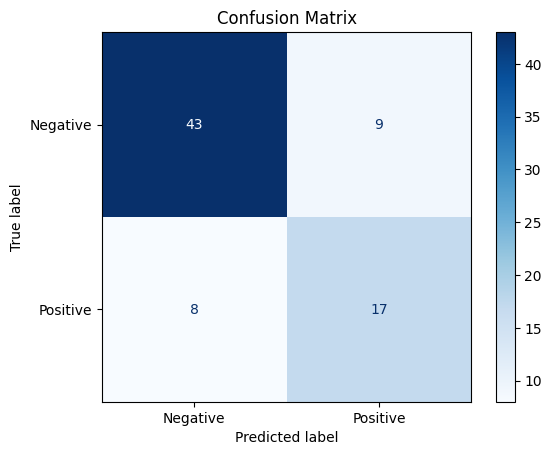


Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.83      0.83        52
    Positive       0.65      0.68      0.67        25

    accuracy                           0.78        77
   macro avg       0.75      0.75      0.75        77
weighted avg       0.78      0.78      0.78        77

Number of selected features: 78
Shape of SHAP values: (258, 78)


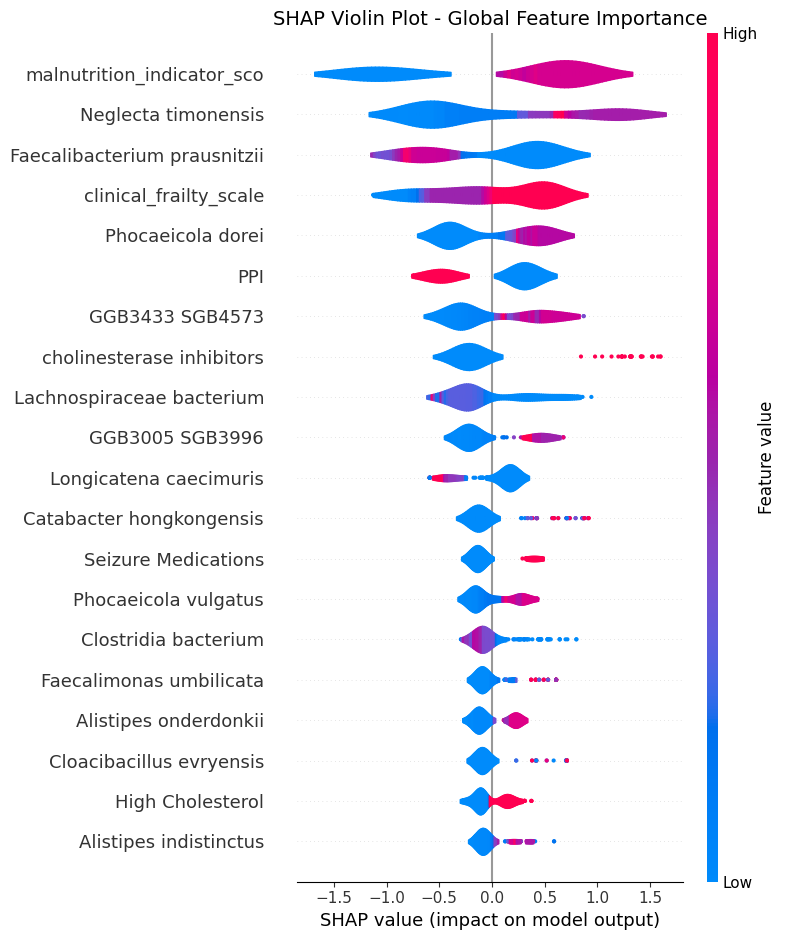

Overlap bacteria found: {'Faecalimonas_umbilicata', 'Clostridiaceae_bacterium', 'Bacteroides_cellulosilyticus', 'Ruminococcus_gnavus', 'Bacteroides_thetaiotaomicron', 'GGB9581_SGB14999', 'GGB3293_SGB4348', 'Cloacibacillus_evryensis', 'Alistipes_finegoldii', 'Massilimicrobiota_sp_An134', 'Tyzzerella_nexilis', 'Enterocloster_citroniae', 'Clostridium_leptum', 'Alistipes_onderdonkii', 'GGB9627_SGB15081', 'Emergencia_timonensis', 'Ruminococcus_bromii', 'Alistipes_communis', 'Phocaeicola_vulgatus', 'GGB9524_SGB14924', 'Clostridioides_difficile', 'Ruminococcus_SGB4421', 'Gemmiger_formicilis', 'Ruthenibacterium_lactatiformans', 'Faecalibacterium_prausnitzii', 'Alistipes_indistinctus', 'Clostridia_bacterium_UC5_1_1E11', 'GGB3433_SGB4573', 'Longicatena_caecimuris', 'Clostridiales_bacterium', 'Lachnospiraceae_bacterium', 'Escherichia_coli', 'Neglecta_timonensis', 'Bacteroides_xylanisolvens', 'Bacteroides_caccae', 'Lachnospiraceae_unclassified_SGB66069', 'Phascolarctobacterium_succinatutens', 'Ana

In [14]:
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    roc_curve, roc_auc_score, f1_score, accuracy_score, confusion_matrix, 
    classification_report, ConfusionMatrixDisplay
)

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# Constants and Configuration
print(f"Experiment number: {experiment_number} | Seed number: {seed}")
# seed = experiment_seed  # Replace with your experiment seed
test_size = 0.25
gpu_device = "hist"

# Function to check for overlaps between train and test data
def check_for_overlap(train_data, test_data):
    """
    Checks for overlapping Sample ID and study_id between train and test datasets.
    """
    # Check for overlapping Study IDs
    overlap_study_ids = set(train_data["study_id"]) & set(test_data["study_id"])
    if overlap_study_ids:
        print(f"Overlap Study ID found: {overlap_study_ids}")
    else:
        print("No overlap Study ID found.")

    # Check for overlapping Sample IDs
    overlap_sample_ids = set(train_data["Sample ID"]) & set(test_data["Sample ID"])
    if overlap_sample_ids:
        print(f"Overlap Sample ID found: {overlap_sample_ids}")
    else:
        print("No overlap Sample ID found.")

def check_for_bacteria(list_a, list_b):
    """
    Checks for overlapping bactertia from list_a and list list_b database and predicted bacteria.
    """
    # Check for overlapping Study IDs
    list_a = [item.replace(" ", "_") for item in list_a]
    list_b = [item.replace(" ", "_") for item in list_b]
    
    overlap_bacteria = set(list_a) & set(list_b)
    if overlap_bacteria:
        print(f"Overlap bacteria found: {overlap_bacteria}")
    else:
        print("No overlap bacteria found.")
    return overlap_bacteria

        
def preprocess_data(df, columns_to_drop, test_size, seed):
    # Split study IDs into train/test sets
    study_labels = df.groupby("study_id")["Alzheimers"].max().reset_index()
    train_ids, test_ids = train_test_split(
        study_labels["study_id"],
        test_size=test_size,
        stratify=study_labels["Alzheimers"],
        random_state=seed,
    )
    
    train_data = df[df["study_id"].isin(train_ids)].copy()
    test_data = df[df["study_id"].isin(test_ids)].copy()

    # Check for overlaps
    check_for_overlap(train_data, test_data)
    
    # Select feature columns
    feature_columns = [col for col in df.columns if col not in columns_to_drop]

    # Convert feature columns to float64 to ensure compatibility
    train_data[feature_columns] = train_data[feature_columns].astype(np.float64)
    test_data[feature_columns] = test_data[feature_columns].astype(np.float64)

    # Normalize the feature columns
    scaler = StandardScaler()
    train_data.loc[:, feature_columns] = scaler.fit_transform(train_data[feature_columns])
    test_data.loc[:, feature_columns] = scaler.transform(test_data[feature_columns])

    return train_data, test_data, feature_columns

# Function to compute class weights
def compute_weights(y_train):
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0]
    return scale_pos_weight

# Define Optuna Objective Function
def objective(trial, X_train, y_train, scale_pos_weight, seed):
    print(f"Seed in the model {seed} on Device {device}")
    # Feature selection parameters
    threshold = trial.suggest_categorical('threshold', ['median', 'mean', '0.5*mean', '1.5*mean', 'very_low'])
    max_features = trial.suggest_int('max_features', 1, X_train.shape[1])
    norm_order = trial.suggest_int('norm_order', 1, 2)
    threshold_value = -1e10 if threshold == 'very_low' else threshold

    # Feature selection
    selector = SelectFromModel(
        estimator=XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight= scale_pos_weight,
            random_state=seed,
            tree_method=gpu_device, 
            device=device
        ),
        threshold=threshold_value,
        max_features=max_features,
        norm_order=norm_order
    )
    
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)

    # Define XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,
        'seed': seed,
        'tree_method': gpu_device,
        'device': device
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    f1_scores = []
    for train_idx, val_idx in skf.split(X_train_selected, y_train):
        X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=trial.suggest_int("n_estimators", 50, 300),
            evals=[(dtrain, 'train'), (dval, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        y_val_pred = model.predict(dval)
        y_val_pred_binary = (y_val_pred >= 0.5).astype(int)
        f1_scores.append(f1_score(y_val_fold, y_val_pred_binary))
    return np.mean(f1_scores)

# Main Program
columns_to_drop = ["Sample ID", "study_id", "Alzheimers", "Date Sample", "age", "Dementia Other"] # "malnutrition_indicator_sco", "clinical_frailty_scale", "PPI", 

train_data, test_data, feature_columns = preprocess_data(clinical_microbiome_df, columns_to_drop, test_size, seed)
X_train = deepcopy(train_data[feature_columns].values)
y_train = np.array(train_data["Alzheimers"].values)
X_test = deepcopy(test_data[feature_columns].values)
y_test = np.array(test_data["Alzheimers"].values)
scale_pos_weight = compute_weights(y_train)

# Run Optuna Optimization
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=seed))
study.optimize(lambda trial: objective(trial, X_train, y_train, scale_pos_weight, seed), n_trials=100)

# Best Parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Apply Final Model
final_selector = SelectFromModel(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=seed,
        tree_method=gpu_device,
        device=device,
        scale_pos_weight=scale_pos_weight
    ),
    
    threshold=-1e10 if best_params['threshold'] == 'very_low' else best_params['threshold'],
    max_features=best_params['max_features'],
    norm_order=best_params['norm_order']
)

final_selector.fit(X_train, y_train)
X_train_selected = final_selector.transform(X_train)
X_test_selected = final_selector.transform(X_test)

# Train Final Model
final_model_params = {
    **{k: v for k, v in best_params.items() if k not in ['threshold', 'norm_order', 'max_features', 'n_estimators']},
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'seed': seed,
    'tree_method': gpu_device,
    'device': device
}

dtrain_final = xgb.DMatrix(X_train_selected, label=y_train)
dtest_final = xgb.DMatrix(X_test_selected)

final_model = xgb.train(
    params=final_model_params,
    dtrain=dtrain_final,
    num_boost_round=best_params['n_estimators'],
)

# Predictions and Evaluation
y_test_pred = final_model.predict(dtest_final)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
auc = roc_auc_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

print("\nTest Metrics:")
print(f"ROC AUC: {auc}\nAccuracy: {accuracy}\nF1 Score: {f1}\nConfusion Matrix:\n{conf_matrix}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_test_pred_binary, target_names=["Negative", "Positive"])
print("\nClassification Report:")
print(report)

# Extract feature names for selected features
selected_feature_names = [feature_columns[i] for i in final_selector.get_support(indices=True)]
print(f"Number of selected features: {len(selected_feature_names)}")

# Step 1: Initialize SHAP explainer
explainer = shap.Explainer(final_model, X_train_selected)

# Step 2: Compute SHAP values
shap_values = explainer(X_train_selected, check_additivity=False)

# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [15]:
auc

np.float64(0.7423076923076923)

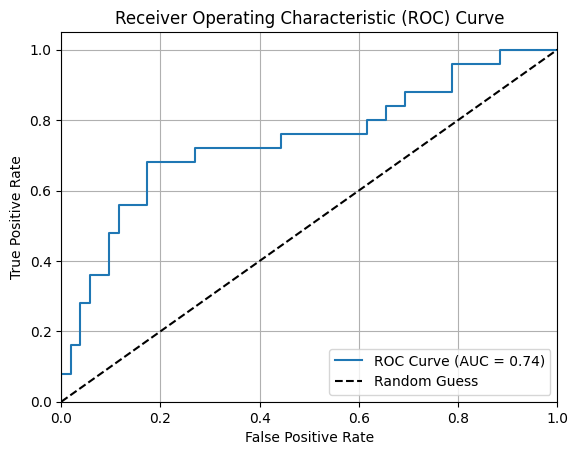

In [16]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [17]:
accuracy

0.7792207792207793

In [18]:
f1

np.float64(0.6666666666666666)

In [19]:
conf_matrix

array([[43,  9],
       [ 8, 17]])

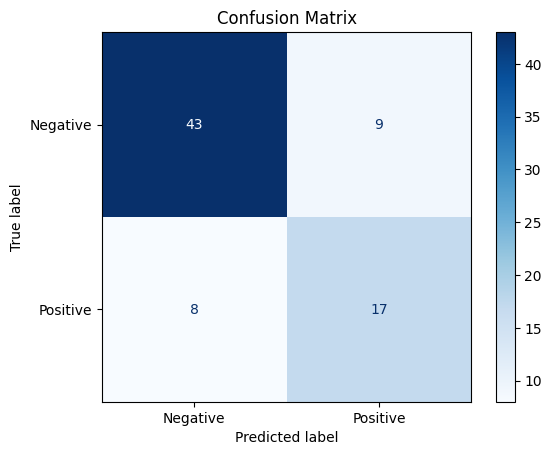

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

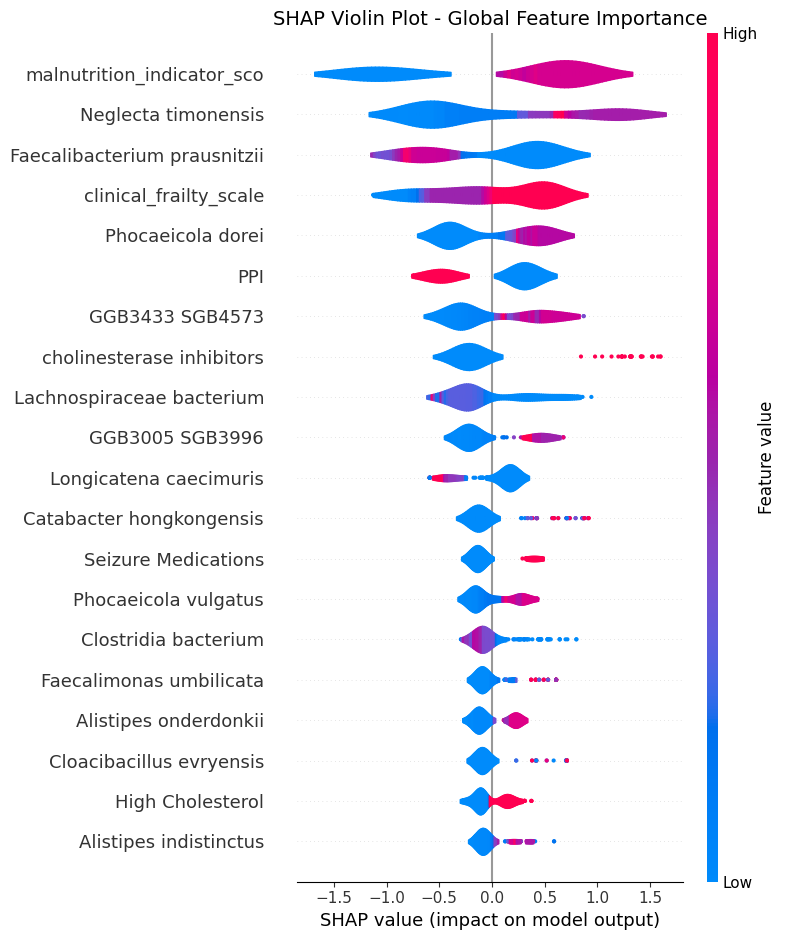

Overlap bacteria found: {'Faecalimonas_umbilicata', 'Clostridiaceae_bacterium', 'Bacteroides_cellulosilyticus', 'Ruminococcus_gnavus', 'Bacteroides_thetaiotaomicron', 'GGB9581_SGB14999', 'GGB3293_SGB4348', 'Cloacibacillus_evryensis', 'Alistipes_finegoldii', 'Massilimicrobiota_sp_An134', 'Tyzzerella_nexilis', 'Enterocloster_citroniae', 'Clostridium_leptum', 'Alistipes_onderdonkii', 'GGB9627_SGB15081', 'Emergencia_timonensis', 'Ruminococcus_bromii', 'Alistipes_communis', 'Phocaeicola_vulgatus', 'GGB9524_SGB14924', 'Clostridioides_difficile', 'Ruminococcus_SGB4421', 'Gemmiger_formicilis', 'Ruthenibacterium_lactatiformans', 'Faecalibacterium_prausnitzii', 'Alistipes_indistinctus', 'Clostridia_bacterium_UC5_1_1E11', 'GGB3433_SGB4573', 'Longicatena_caecimuris', 'Clostridiales_bacterium', 'Lachnospiraceae_bacterium', 'Escherichia_coli', 'Neglecta_timonensis', 'Bacteroides_xylanisolvens', 'Bacteroides_caccae', 'Lachnospiraceae_unclassified_SGB66069', 'Phascolarctobacterium_succinatutens', 'Ana

In [21]:
# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

Shape of SHAP values: (258, 78)


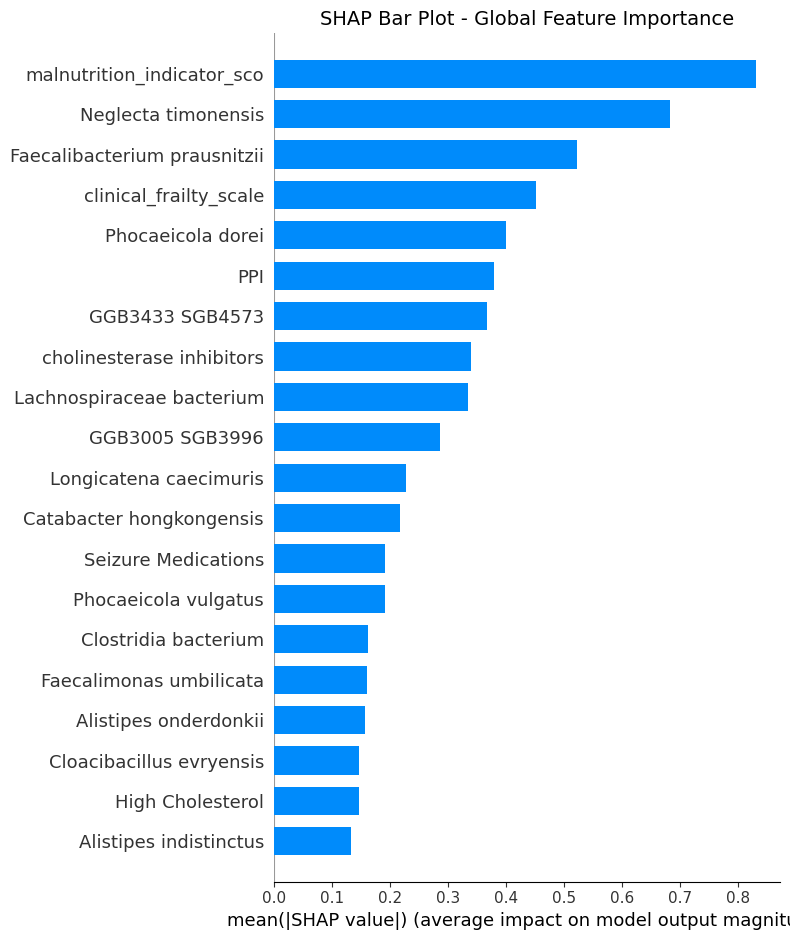

Overlap bacteria found: {'Faecalimonas_umbilicata', 'Clostridiaceae_bacterium', 'Bacteroides_cellulosilyticus', 'Ruminococcus_gnavus', 'Bacteroides_thetaiotaomicron', 'GGB9581_SGB14999', 'GGB3293_SGB4348', 'Cloacibacillus_evryensis', 'Alistipes_finegoldii', 'Massilimicrobiota_sp_An134', 'Tyzzerella_nexilis', 'Enterocloster_citroniae', 'Clostridium_leptum', 'Alistipes_onderdonkii', 'GGB9627_SGB15081', 'Emergencia_timonensis', 'Ruminococcus_bromii', 'Alistipes_communis', 'Phocaeicola_vulgatus', 'GGB9524_SGB14924', 'Clostridioides_difficile', 'Ruminococcus_SGB4421', 'Gemmiger_formicilis', 'Ruthenibacterium_lactatiformans', 'Faecalibacterium_prausnitzii', 'Alistipes_indistinctus', 'Clostridia_bacterium_UC5_1_1E11', 'GGB3433_SGB4573', 'Longicatena_caecimuris', 'Clostridiales_bacterium', 'Lachnospiraceae_bacterium', 'Escherichia_coli', 'Neglecta_timonensis', 'Bacteroides_xylanisolvens', 'Bacteroides_caccae', 'Lachnospiraceae_unclassified_SGB66069', 'Phascolarctobacterium_succinatutens', 'Ana

In [22]:
# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Bar Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="bar"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [23]:
measures = ["xgboost", seed, experiment_number, accuracy, auc, f1]

# Create a DataFrame with appropriate column names
columns = ["Model", "Seed", "Experiment_Number", "Accuracy", "AUC", "F1_Score"]
measures_df = pd.DataFrame([measures], columns=columns)
measures_df

,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,xgboost,513873336,8,0.779221,0.742308,0.666667


In [24]:
output_path = "output"
measures_path = f"{output_path}{os.sep}xgboost_experiment{experiment_number:02d}_measures.csv"
if output_path and not os.path.exists(output_path):
    os.makedirs(output_path)
measures_path

'output/xgboost_experiment08_measures.csv'

In [25]:
measures_df.to_csv(measures_path, index=False)